# SPARC Visualizer Africa

In this notebook we will try to replicate the following [interactive map](https://javierfajnolla.shinyapps.io/SPARC_visualizer_Africa/).

**Information from Patrick Roehrdanz:**

I've attached a [folder](https://drive.google.com/file/d/1dNVBhfjjO5q0W2R1oRGpHmeqKzzaPTnY/view?usp=sharing) with all the data and code used for an example shiny app with conservation priorities and carbon for Africa.  

The raster in the `./data/solutions/` folder called `AT_Birds_gf8570_BLP1_noPA.CAZ_EBLP100.rank.compressed.tif` is a zonation output where all pixels are placed in order according to their conservation values (lots goes into that of course).  This raster was then thresholded at 1% intervals to pre-compute a table of the associated carbon value at each threshold to reduce the interactive compute load of the sliders -- resulting table is `AT_tbl.rds` in the `./data/tables/` folder.  This version is a bit more stable than the earlier new guinea one but the sliders still get stuck in a loop on occasion.

We will be producing many flavors of prioritization grids like this -- at 2.5 minute resolution for continental scales and at 30 arc second resolution for selected focal areas (groups of countries).


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
import rasterio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Using python and data from a local folder

First we replicate the computation done in the `global.R` and `server.R` files taking the rasters from a local folder. 

**Read the zonation output raster**

In [2]:
with rasterio.open('./SPARC_Visualizer_Africa/data/solutions/AT_Birds_gf8570_BLP1_noPA.CAZ_EBLP100.rank.compressed.tif') as src:
    profile = src.profile
    transform = src.transform
    solution = src.read(1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


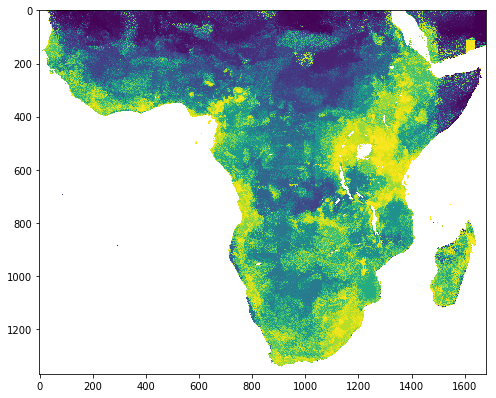

In [3]:
solution[solution == solution.min()] = np.nan
plt.figure(figsize=(8,8))
plt.imshow(solution)

**Read carbon storage**

In [4]:
with rasterio.open('./SPARC_Visualizer_Africa/data/solutions/AT_total_carbon_2_5m.tif') as src:
    profile = src.profile
    transform = src.transform
    carbon_stor = src.read(1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


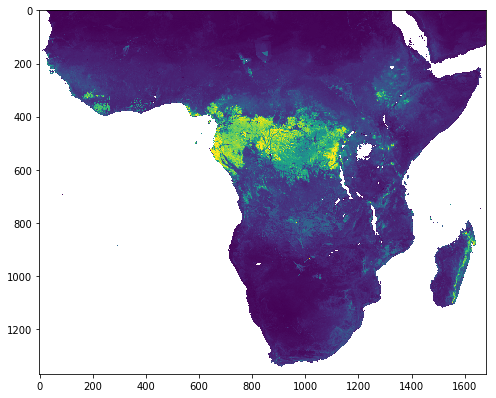

In [5]:
carbon_stor[carbon_stor == carbon_stor.min()] = np.nan
plt.figure(figsize=(8,8))
plt.imshow(carbon_stor, vmax=15000)

In [6]:
carbon_stor.max()

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


nan

**Create table**

Description of each column:
- `perc_pixels`: percentage of pixels in the studied area
- `cutoff_sol`: cutoff value that retains each percentage of pixels in the studied area
- `carbon_strg`: total carbon storage saved in each range
- `prop_carbon_strg`: proportion of the carbon storage saved in each range
- `prop_carbon_strg_rounded`: raunded value of `prop_carbon_strg`

In [7]:
tbl = pd.DataFrame(columns=['perc_pixels'])
tbl['perc_pixels'] = np.arange(0.01,1.01,0.01)

Total carbon storage in the studied area

In [8]:
total_carbon = np.nansum(carbon_stor)
print(total_carbon)

2816489000.0


Sort solution array values in a vector

In [9]:
sol_values_sort = np.reshape(solution,solution.shape[0]*solution.shape[1])
sol_values_sort = sol_values_sort[~np.isnan(sol_values_sort)]
sol_values_sort = np.sort(sol_values_sort)[::-1]

**Cutoff in solution to retain each percentage of the study area**

We take the cutoff value that retains each percentage of pixels in the studied area

In [10]:
cutoff_sol = []
carbon_strg = []
prop_carbon_strg = []
for i in range(len(tbl)):
    
    # cutoff value that retains each percentage of pixels in the studied area
    cutoff = sol_values_sort[int(round(len(sol_values_sort) * tbl.perc_pixels.iloc[i]))-1]
    cutoff_sol.append(cutoff)
    
    # total carbon storage saved in each range
    total_carbon_cutoff = np.nansum(carbon_stor[np.where(solution > cutoff)])
    carbon_strg.append(total_carbon_cutoff)
    
    # proportion of the carbon storage saved in each range
    prop_carbon_strg.append(total_carbon_cutoff/total_carbon)
    
tbl['cutoff_sol'] = cutoff_sol
tbl['carbon_strg'] = carbon_strg
tbl['prop_carbon_strg'] = prop_carbon_strg
tbl['prop_carbon_strg_rounded'] = tbl['prop_carbon_strg'].apply(lambda x: round(x, 2))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [12]:
tbl.head()

,perc_pixels,cutoff_sol,carbon_strg,prop_carbon_strg,prop_carbon_strg_rounded
0,0.01,0.990001,57881120.0,0.020551,0.02
1,0.02,0.980001,105617480.0,0.037500,0.04
2,0.03,0.970001,151672720.0,0.053852,0.05
3,0.04,0.960001,194798352.0,0.069164,0.07
4,0.05,0.950001,234993888.0,0.083435,0.08


**SPARC Visualizer**

We can modify two slider.
- `Conservation Priority`: 
    - min = 1
    - max = 100
    - step = 1 
    - `Solution threshold` in the SPARC visualizer legend 
    - `perc_pixels` column in the table.
- `Carbon Percentage`:
    - min = 0
    - max = 100
    - step = 1 
    - `Carbon offset` in the SPARC visualizer legend 
    - `prop_carbon_strg` column in the table.
    
- `New Slider`:
    - min = 0
    - max = 99
    - step = 1 
    - `number of rows` in the table.

In [13]:
def show_layer(thr1):
    
    cutoff_sol = tbl[round(tbl['perc_pixels'], 2) == round(thr1/100, 2)]['cutoff_sol'].iloc[0]
    
    mask = np.full(solution.shape, np.nan)
    mask[np.where(solution > cutoff_sol)] = 1
    
    x = np.array(tbl['perc_pixels'])
    y = np.array(tbl['prop_carbon_strg'])
    
    x_cutoff = np.array(tbl[tbl['cutoff_sol'] >= cutoff_sol]['perc_pixels'])
    y_cutoff = np.array(tbl[tbl['cutoff_sol'] >= cutoff_sol]['prop_carbon_strg'])
    
    plt.figure(figsize = (16,8))
    gs = gridspec.GridSpec(1, 2)
    gs.update(wspace=0.2, hspace=0.05) # set the spacing between axes. 
    
    ax = plt.subplot(gs[0])
    ax.imshow(mask)
    
    ax = plt.subplot(gs[1])
    ax.fill_between(x*100, y*100)
    ax.fill_between(x_cutoff*100, y_cutoff*100, color='r')
    ax.set_xlabel('Proportion of study area protected', fontsize=10)
    ax.set_ylabel('Proportion of carbon storage saved')

In [14]:
def rows_slider(thr):
    """
    thr -> Number or row in the table 
    """
    if thr not in range(0,100,1) : thr = 50
    
    thr1 = int(tbl.perc_pixels.iloc[thr]*100)
    thr2 = int(tbl.prop_carbon_strg_rounded.iloc[thr]*100)
    
    print("Solution threshold:", thr1)
    print("Carbon offset:", thr2)
    
    show_layer(thr1)

Solution threshold: 11
Carbon offset: 16


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


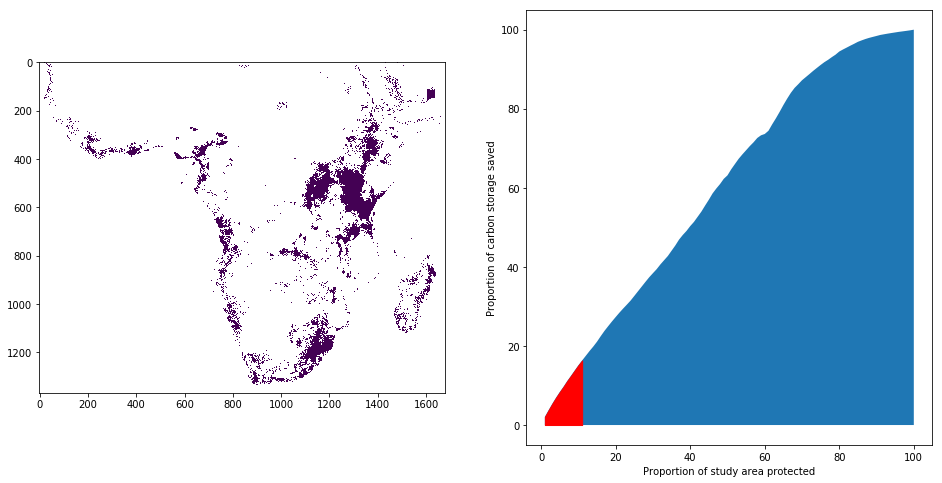

In [15]:
rows_slider(10)

## Using python and data from GEE

In [16]:
import ee
import requests
import folium

ee.Initialize()

In [17]:
def tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
    return url

**Display the zonation output raster**

In [25]:
image1 = ee.Image(f'projects/SPARC_team/Birds/rank_africa')

image1_tiles = tile_url(image1, {})

carbon_map = folium.Map(location=[-7., 16.], zoom_start=4, tiles='Mapbox Bright' )
carbon_map.add_tile_layer(tiles=image1_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
carbon_map

In [24]:
image1 = ee.Image(f'projects/SPARC_team/Birds/rank_africa_integer')

image1_tiles = tile_url(image1, {'min':0, 'max':100})

carbon_map = folium.Map(location=[-7., 16.], zoom_start=4, tiles='Mapbox Bright' )
carbon_map.add_tile_layer(tiles=image1_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
carbon_map

**Display the carbon storage layer**

In [23]:
image2 = ee.Image(f'projects/SPARC_team/Birds/total_carbon_africa')


image2_tiles = tile_url(image2, {'max':15000, 'palette': "#492000, #642C00, #883B00, #A84A00, #D95F00, #FB7004, #FF8E35"})

carbon_map = folium.Map(location=[-7., 16.], zoom_start=4, tiles='Mapbox Bright' )
carbon_map.add_tile_layer(tiles=image2_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
carbon_map

**Display mask**

In [27]:
mask = image1.gte(0.50)
mask = mask.updateMask(mask)

mask_tiles = tile_url(mask, {'palette':"#8B0000"})

mask_map = folium.Map(location=[-7., 16.], zoom_start=3, tiles='Mapbox Bright' )
mask_map.add_tile_layer(tiles=mask_tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
mask_map

## Exporting the data to a Google Cloud Bucket

We export the tiles to a goggle cloud bucket [code](https://code.earthengine.google.com/5797ceb7badb3b4d5850c0437128fc82)

In [31]:
tiles = 'https://storage.googleapis.com/sparc-cache/Africa/Birds/{z}/{x}/{y}.png'   
map = folium.Map(location=[-7., 16.], zoom_start=4, tiles='Mapbox Bright' )
map.add_tile_layer(tiles=tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
map

In [30]:
tiles = 'https://storage.googleapis.com/sparc-cache/Africa/Carbon/{z}/{x}/{y}.png'   
map = folium.Map(location=[-7., 16.], zoom_start=4, tiles='Mapbox Bright' )
map.add_tile_layer(tiles=tiles, max_zoom=19, min_zoom=1, attr="Live EE tiles")
map